# Importing Libraries

In [219]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from nose.tools import *
import time
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV,cross_val_score 
from sklearn import preprocessing
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_log_error,mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import ensemble 
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os

## Reading the data

In [121]:
df = pd.read_csv("C:/Users/askma/OneDrive/Desktop/IS_665/london_merged.csv")
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [122]:
l = df.columns
l

Index(['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code',
       'is_holiday', 'is_weekend', 'season'],
      dtype='object')

# Data Cleaning

<AxesSubplot:>

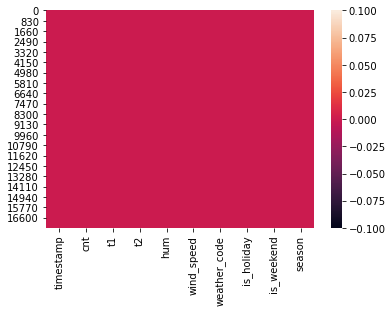

In [123]:
sns.heatmap(df.isna())

In [124]:
df.shape[0]//2

8707

In [125]:
c=0
for i in range(df.shape[1]):
    if(df[l[i]].isna().sum() > df.shape[0]//2):
        df.drop([l[i]],axis=1,inplace = True)
        print("dropping ",l[i]," !!!! ")
        c=c+1
print(c)

0


In [126]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [127]:
nl = df.columns[df.isna().any()].tolist()
nl

[]

## No null values found and hence it is a clean dataset

## Now we will remove any outliers as part of feature engineering

In [128]:
df[np.abs(df["cnt"]-df["cnt"].mean()) <=(3*df["cnt"].std())]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


# Exploratory Data Analysis and Feature Engineering

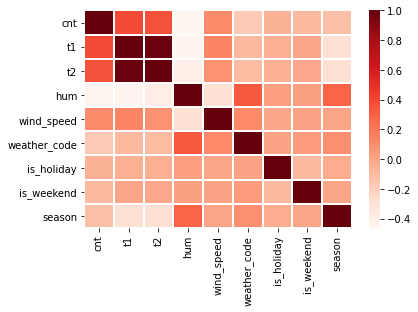

In [129]:
plt.figure()
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths = 1,cmap="Reds")
plt.show()

<AxesSubplot:xlabel='season', ylabel='cnt'>

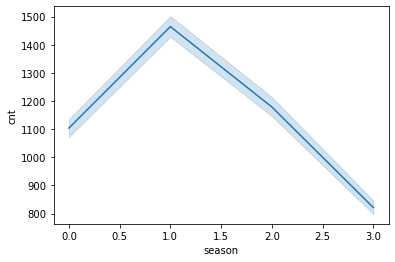

In [130]:
sns.lineplot(x=df.season, y=df.cnt,data=df)

Let us create a better view for this graph as the correlation is there, we will now make the most of the timestamp given to us as we will stratify it to get the hour, day of the week, day of month, month and year, I initially just did month and then when I tried to add the other startifying factors it gave me an error so if you look at the next line, that is where I have startified the timestamp column as after the initial Month stratification.

In [131]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format ="%Y-%m-%d %H:%M:%S")

In [132]:
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
df['day'] =df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,month,year,day,hour
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,1,2015,6,0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,2015,6,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,1,2015,6,2
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,1,2015,6,3
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,1,2015,6,4


<AxesSubplot:xlabel='month', ylabel='cnt'>

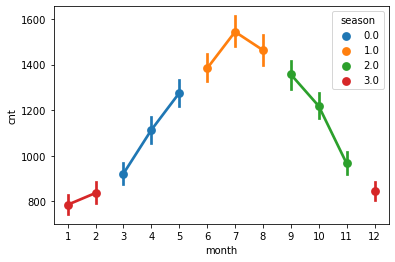

In [133]:
sns.pointplot(x=df.month,y=df.cnt,data=df,hue = df.season)

We see that there is a steady rise starting from March and it keeps on rising till July and then it gradually starts decreasing till December, so it looks like during the summer there are the most bike shares

Now that we have established a correlation between season/month we will now move on to see the trend for the week

<AxesSubplot:xlabel='day', ylabel='cnt'>

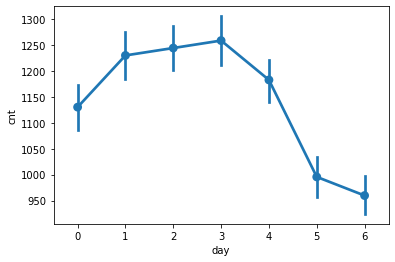

In [134]:
sns.pointplot(x=df.day,y=df.cnt,data=df)

We can see that during the weekends less people go for bikes compared to the work week

Now lets see how the hourly breakdown looks like

In [135]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,month,year,day,hour
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,1,2015,6,0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,2015,6,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,1,2015,6,2
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,1,2015,6,3
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,1,2015,6,4


<AxesSubplot:xlabel='hour', ylabel='cnt'>

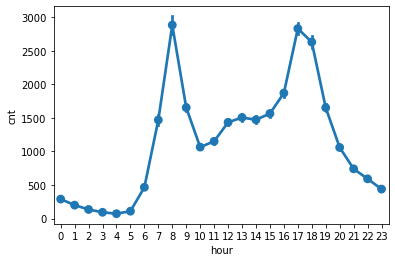

In [136]:
sns.pointplot(x=df.hour,y=df.cnt,data=df)

This is the general trend for hourly breakdown, we can see that just before the 9am work start so at 8am it is the highest which suggests that lots of people use bikes to get to work and then it rises to almost same numbers at 5pm when people are returning home.

Now let us see the trend for holidays

<AxesSubplot:xlabel='hour', ylabel='cnt'>

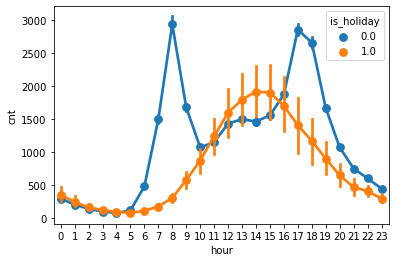

In [137]:
sns.pointplot(x=df.hour,y=df.cnt,data=df,hue = df.is_holiday)

As expected, during holodays, people prefer to wake up later and then go for bike rides in the afternoon times

Now let us see the trend for weekends

<AxesSubplot:xlabel='hour', ylabel='cnt'>

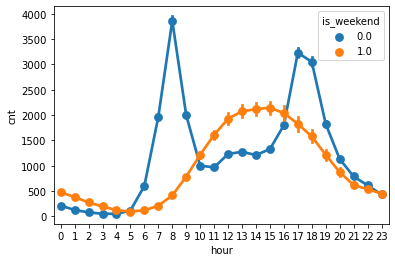

In [138]:
sns.pointplot(x=df.hour,y=df.cnt,data=df,hue = df.is_weekend)

We see that it is more or less similar to the holiday trend

Now we will see the trend with regards to humidity

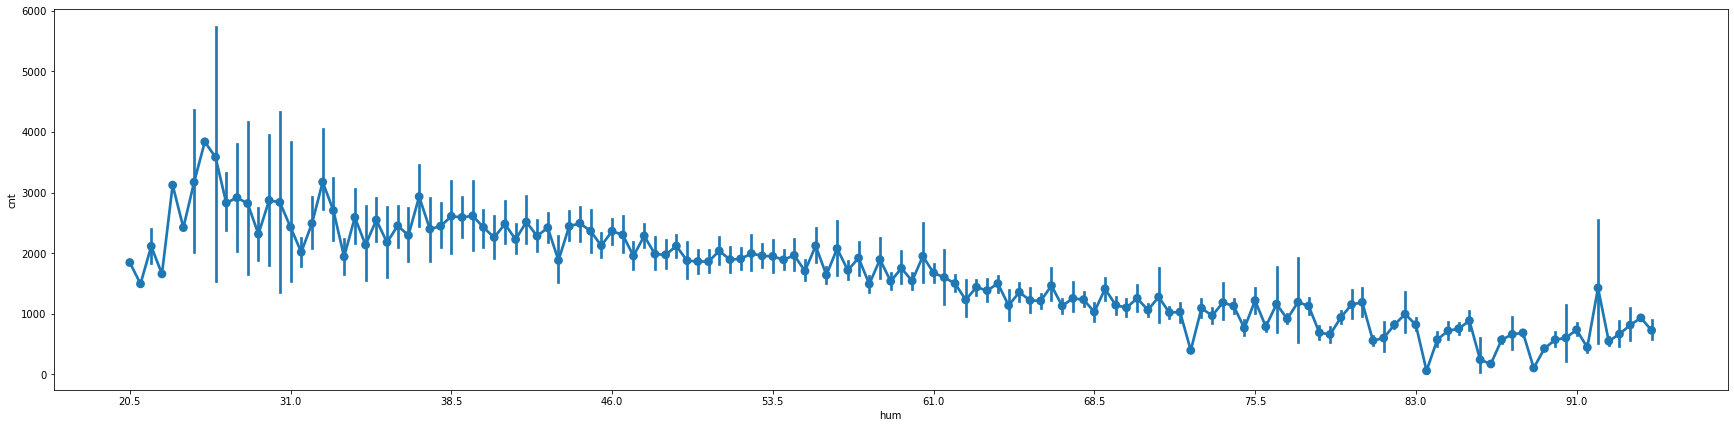

In [139]:
plt.figure(figsize=(30, 7))
sns.pointplot(x=df.hum,y=df.cnt,data=df)
plt.locator_params(axis='x', nbins=10)

We see that as the humidity increases the count of bike shares decreases, so it can be said that during the summer months and around that time period, the humidity tends to stay on the lower side as the graph below proves so.

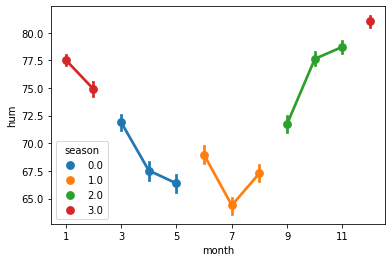

In [140]:
sns.pointplot(x=df.month,y=df.hum,data=df, hue=df.season)
plt.locator_params(axis='x', nbins=10)

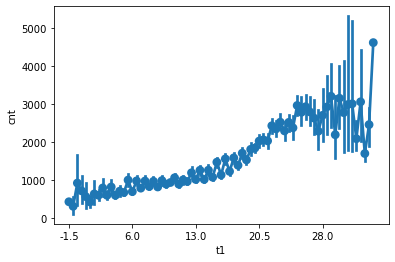

In [141]:
sns.pointplot(x=df.t1,y=df.cnt,data=df)
plt.locator_params(axis='x', nbins=5)

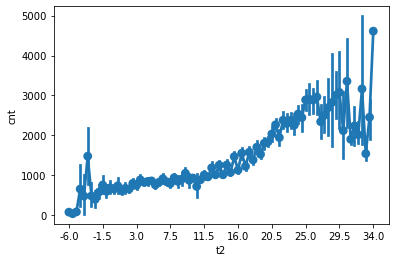

In [142]:
sns.pointplot(x=df.t2,y=df.cnt,data=df)
plt.locator_params(axis='x', nbins=10)

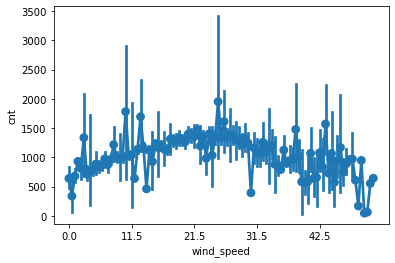

In [143]:
sns.pointplot(x=df.wind_speed,y=df.cnt,data=df)
plt.locator_params(axis='x', nbins=5)

<AxesSubplot:xlabel='weather_code', ylabel='cnt'>

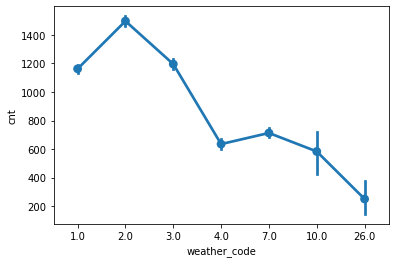

In [144]:
sns.pointplot(x=df.weather_code,y=df.cnt,data=df)

<AxesSubplot:xlabel='weather_code', ylabel='month'>

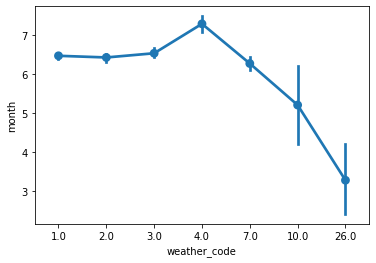

In [145]:
sns.pointplot(x=df.weather_code,y=df.month,data=df)

# Machine Learning

Observing the shape of the dataframe

In [146]:
X = df.copy()
X.shape

(17414, 14)

Adding a column called count_log which will reduce the variance in the data and will also help to reduce the effect of outliers in the data even though we have removed the outliers previously, just to be completely sure

In [147]:
df['count_log'] = np.log1p(df['cnt'])

In [148]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,month,year,day,hour,count_log
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,1,2015,6,0,5.209486
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,2015,6,1,4.934474
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,1,2015,6,2,4.905275
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,1,2015,6,3,4.290459
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,1,2015,6,4,3.871201


We are stratifying our X and y and also using scaler to standardize our feature values

In [207]:
new_df = df.drop(['timestamp'],axis=1)
X = new_df.drop(['count_log'], axis=1)
y = new_df['count_log']
scaler_x = preprocessing.MinMaxScaler()
X =  pd.DataFrame(scaler_x.fit_transform(X), columns = X.columns)

In [208]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42)

In [209]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(13931, 13) (3483, 13) (13931,) (3483,)


I have used Liner, Ridge, Lasso, ElasticNet and Polynomial regressions

In [210]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X_train,y_train)
slr.predict(X_test)
slr.score(X_test, y_test)

0.796334739020761

In [211]:
from sklearn.kernel_ridge import KernelRidge
krr = KernelRidge(alpha = 1.0)
krr.fit(X_train,y_train)
krr.predict(X_test)
krr.score(X_test, y_test)

0.5886084562767719

In [212]:
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
X_train, y_train = make_regression(noise=4, random_state=0)
reg = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
model = Lasso(alpha=1.0)
model.fit(X_train, y_train)
yhat2 = model.predict(X_test)
r2_score(y_test, yhat2)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 100 is different from 13)

In [213]:
from sklearn.linear_model import ElasticNet
scaler = StandardScaler().fit(X_train)
rescaled_X_train = scaler.transform(X_train)
model = ElasticNet(random_state=21)
model.fit(rescaled_X_train, y_train)
predictions = model.predict(X_train)
print(predictions)

[ -57.51298553  -52.67764801   92.45326507   33.17842762 -110.13328073
  -68.97743311   88.19094719 -102.16994205   45.4932118  -149.08698763
  138.60266121   53.39008289  -39.91481474   68.01333721 -101.19122466
  -18.61903948   91.8133725   210.10329544   86.908492    -16.40440219
  -63.18637849 -131.38498163   17.374957    -35.28925502   73.9451564
 -135.52213974 -176.13272399 -101.16853385   31.27979632 -148.89580634
   26.60314748  -49.72824701   16.10193245 -139.32793555  107.5639142
  -97.08993288  -27.54624719  -24.01119603 -153.20574664 -184.27646443
   78.39953749    3.44250684   15.38038692    1.70937184  -44.58834243
  -89.14119285 -130.91764212 -190.31311608  -68.98459407 -125.22033314
 -113.21905021    6.86372116 -125.31067534   34.06436184   -3.24961786
   13.46698221  -30.49477089 -153.59319858   34.81998071  -26.54943196
 -149.77942669  126.00293479   -6.30212377 -134.97421416   -7.87375349
  116.42515148  139.59584478   46.28069873  -70.28526012  -25.32522365
  -93.39

In [218]:
import numpy
import matplotlib.pyplot as plt

mymodel = numpy.poly1d(numpy.polyfit(X_train['cnt'], y_train))
print(r2_score(y_train, mymodel(X_train)))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices